In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as mpl
import logging
import sys
import os
import matplotlib.pyplot as plt

# This adds the code/ project directory to the path, so that it is available to be imported.
# From there you can import, e.g. the error_correction library
lib_path = os.path.abspath("../")
print(lib_path)
if lib_path not in sys.path:
    sys.path.append(lib_path)

/home/marcocofano/projects/qkd_reconciliation_lectures/code


In [3]:
!pip install -e ../

Obtaining file:///home/marcocofano/projects/qkd_reconciliation_lectures/code
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for error_correction (pyproject.toml) ... done
  Created wheel for error_correction: filename=error_correction-0.1.0-py3-none-any.whl size=1265 sha256=9055008e3de178e3d6116e51b141fc5e463e64b4539144e4651b56486850bf76
  Stored in directory: /tmp/pip-ephem-wheel-cache-m1lxm7f8/wheels/06/92/36/602883b8def36d3cd118f47a565edaff2181855a61acc73c39
Successfully built error_correction


  Attempting uninstall: error_correction
    Found existing installation: error_correction 0.1.0
    Uninstalling error_correction-0.1.0:
      Successfully uninstalled error_correction-0.1.0

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from error_correction.performance import decoding_performance
from error_correction.decoders import BPA, decoder_factory
from error_correction.channels import Channel, channel_factory

from error_correction.codes import Code, CodeConfig
from error_correction.data_dirs import ErrorCorrectionDirs

## Error correction leak in QKD - H  matrix design considerations

The DV Reconciliation protocol is nothing more than a syndrome decoding problem over a BSC, parametrizided by the crossover probabliity p, which in our case will be the same as the QBER.

The leak of information for the Errorc correction protocol is:

$$\delta_{\text{leak}} = f H(A|B) = fh(p) = f(-p\log_2{p} -(1-p)\log_2(1-p)$$

In practice, we have added the efficiency parameter due to the fact that we will be using a specific H matrix (code) with a set Coderate. This decision will determine the actual amount of bits per channel used that we disclose (leak), i.e. the syndrome. The actual rate of disclosure will then be:

$$\delta_{\text{leak}} = 1 - CR$$

We can use the last two formulae to decide which coderate to employ according to the channel conditions. i.e. QBER and the efficiency we want to obtain. The trade-off is that the efficiency needs to be as close to 1 as possible to extract more secret key rate. This is clear by the fact that the $\delta_{\text{leak}}$ will be smaller and less bits will be disclosed in the classical channel. At the same time, higher efficiencies means that we are operating closer to the channel capacity, which puts us in the waterfall region which might increase dramatically the Frame Error Rate. The EC will fail more often, making harder to extract any key.  


### Practical considerations about H matrix design

Designing a single matrix for a specific code is not an easy task.

When designing a practical reconciliation module, we need to prepare a discrete set of matrices with a range of useful Code rates according to the QBERs that we expect and the efficiencies that we would like to obtain.


Obviously, the efficiency is actually obtained looking at the performance of the code itself. This means that a certain Code might work at the relevant efficiency with a certain FER. we should for example design the codes in such a way that they operate @f=1.15 with a FER = 0.1%. This might be a fairly complicated problem that needs to be done in a design phase of your QKD. 

For now we just plot the theoretical values at which we Can Operate according to Coderate and efficiency f

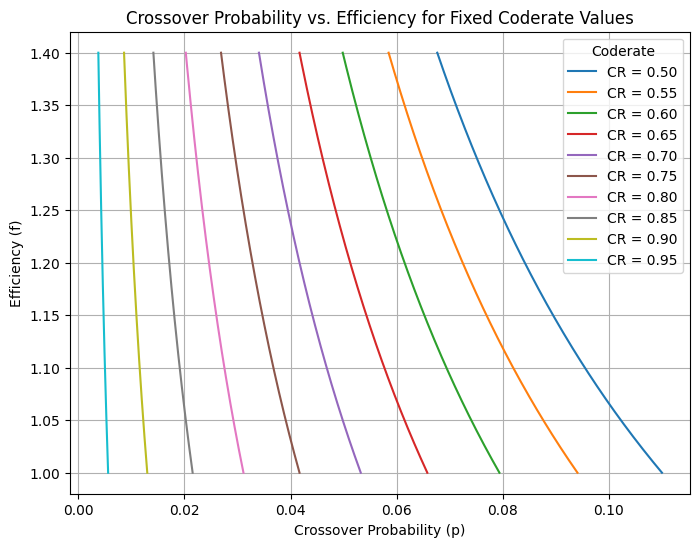

In [7]:
from error_correction import binary_entropy


# Define the range of efficiency values f
f_values = np.linspace(1, 1.40, 200)

# Define the coderate values we want to plot (from 0.5 to 0.9)
coderate_values = np.arange(0.50, 1, 0.05)

plt.figure(figsize=(8,6))

for cr in coderate_values:
    crossprob_values = []
    for f in f_values:
        # For a given coderate and f, we have:
        #   coderate = 1 - f * H₂(p)
        # so that H₂(p) = (1 - coderate) / f.
        h = (1.0 - cr) / f
        p = binary_entropy.binary_entropy_inverse_newton(h)
        crossprob_values.append(p)
    plt.plot(crossprob_values, f_values, label=f'CR = {cr:.2f}')

plt.ylabel("Efficiency (f)")
plt.xlabel("Crossover Probability (p)")
plt.title("Crossover Probability vs. Efficiency for Fixed Coderate Values")
plt.legend(title="Coderate")
plt.grid(True)
plt.show()

Let's say the channel has a p of 0.6. we either use a CR = 0.65 with more efficiency but there our decoder will not be able to decode a lot. Or we use the CR = 0.6 which decodes much better but with a poorer efficency, remember that the secret key rate is:

$$ skr =(1-FER) (H_{\text{min}} - fh(p)) $$
$$f \ge 1$$

In [14]:
def setup_console_logger(level=logging.DEBUG):
    logging.basicConfig(format="%(name)s|%(message)s", level=level)
    return logging.getLogger()

def get_code(name, data_dirs: ErrorCorrectionDirs):
    """Factory function to instantiate a code object from a slug"""
    config = CodeConfig.from_slug(name)
    return Code.from_config(config, data_dirs)

root_data_path = "../error_correction/data"
data_dirs = ErrorCorrectionDirs(root_path=root_data_path)

## [TODO] Insert code to analyze the LDPC code from the point of view of the H Matrix. 
Include:
- N, M degree distribution calculation check, 
- code rate,
- maybe a plot of the matrix and a plot of the Tanner graph or maybe a subsection of it?

- Cycles?


## Code and H matrix analysis

Let's analyse the H matrix of two similar codes. 

- The first one is a random regular ldpc code with degree distribution 3, 6

- The second is an irregular ldpc code that has been optimizes starting from its check degree distribution fixed and trying to find the best variable degree distribution that fullfilled the constraint of having code rate 1/2. This can be done with an Evolution algorithm called Density evolution, which is out of the scope for these lectures. 

Let's just check the matrices parameters and the degree distribution of the second one. 
Can you check the code rate from its degree distribution and confirm that it is very close to 1/2?


You can check the implementation of the methods of the Code class in the error_correction library. 

In [15]:
name = "coo_1200_3-6-randldpc_1"
code = get_code(name, data_dirs)
print(f"Code Density: {code.compute_density()*100:.2f}%")
print(f"Code length and number of parity check equations (cols and rows): {code.get_n()}, {code.get_k()}")
print(f"Code Rate: {code.code_rate()}")
print(f"Degree distribution: {code.compute_degree_distribution()}")

Code Density: 0.50%
Code length and number of parity check equations (cols and rows): 1200, 600
Code Rate: 0.5
Degree distribution: {'check_node_distribution': {np.int64(6): 600}, 'variable_node_distribution': {np.int64(3): 1200}}


In [16]:
name = "coo_1200_rho-x5-randldpc_1"
code = get_code(name, data_dirs)
print(f"Code Density: {code.compute_density()*100:.2f}%")
print(f"Code length and number of parity check equations (cols and rows): {code.get_n()}, {code.get_k()}")
print(f"Code Rate: {code.code_rate()}")
print(f"Degree distribution: {code.compute_degree_distribution()}")

Code Density: 0.50%
Code length and number of parity check equations (cols and rows): 1200, 601
Code Rate: 0.49916666666666665
Degree distribution: {'check_node_distribution': {np.int64(6): 591, np.int64(4): 8}, 'variable_node_distribution': {np.int64(2): 735, np.int64(3): 241, np.int64(1): 2, np.int64(4): 70, np.int64(7): 98, np.int64(5): 3, np.int64(8): 48, np.int64(6): 3}}


# Performance Simulator - FER / Channel transition probabilty plots

In the next piece of code we perform a channel transition probability sweep, we go from a high to low transition probability, bettering the channel conditions. We will see that the decoder will have a high chance of error for worse channels and as you go to better channel conditions (lower noises) the decoder will decode more frames (lower FER)

We will evaluate the coo_1200_3_6_randldpc_1 code which has 1200 input bits and and a code rate of 1/2.

It is a regular LDPC code with degree distribution of j = 3 and l = 6. 

$$\text{CR} = 1 = \frac{j}{l} = \frac{1}{2}$$

We use a SPA decoder over a bsc channel.


> NOTE: The code can be interrupted. There is a DelayedInterrupt implemented that will just interrupt the current channel conditions and skip to the next in the loop. press the stop button on the menu above to skip the current channel condition evaluation.

In [29]:
logger = setup_console_logger(level=logging.INFO)
channel = 'bsc'
decoder = 'spa'
max_iter = 100
min_fec = 100
log_freq = 5
code_name = "coo_1200_3-6-randldpc_1"
channel_class: Channel = channel_factory(channel)
decoder_class: BPA = decoder_factory(decoder)
code = get_code(code_name, data_dirs)
decoder = decoder_class(code.parity_mtx, max_iter=max_iter)
params = np.arange(0.11, 0.05, -0.005)

print(params)




[0.11  0.105 0.1   0.095 0.09  0.085 0.08  0.075 0.07  0.065 0.06  0.055]


To understand why we chose this window of crossover probabilities refer to the first plot. In there, we saw that a code with code rate of 1/2 can span a range between .06 to 0.11 with decent efficiencies. 

root|Starting parameter: 0.110000
root|TOT:22, FEC:22, FER:1.0, BEC:2722, BER:0.1031060606060606
root|TOT:47, FEC:47, FER:1.0, BEC:5850, BER:0.10372340425531915
root|TOT:69, FEC:69, FER:1.0, BEC:8513, BER:0.10281400966183575
root|TOT:95, FEC:95, FER:1.0, BEC:11808, BER:0.10357894736842105
root|TOT:100, FEC:100, FER:1.0, BEC:12463, BER:0.10385833333333333
root|Starting parameter: 0.105000
root|TOT:23, FEC:23, FER:1.0, BEC:2726, BER:0.09876811594202899
root|TOT:48, FEC:48, FER:1.0, BEC:5568, BER:0.09666666666666666
root|TOT:74, FEC:74, FER:1.0, BEC:8536, BER:0.09612612612612613
root|TOT:99, FEC:99, FER:1.0, BEC:11554, BER:0.09725589225589226
root|TOT:100, FEC:100, FER:1.0, BEC:11684, BER:0.09736666666666667
root|Starting parameter: 0.100000
root|TOT:26, FEC:25, FER:0.9615384615384616, BEC:2580, BER:0.08269230769230769
root|TOT:51, FEC:50, FER:0.9803921568627451, BEC:5242, BER:0.08565359477124183
root|TOT:76, FEC:74, FER:0.9736842105263158, BEC:7678, BER:0.08418859649122808
root|TOT:99, F

root|TOT:3758, FEC:24, FER:0.006386375731772219, BEC:1488, BER:0.00032996274614156465
root|TOT:4002, FEC:26, FER:0.006496751624187906, BEC:1599, BER:0.0003329585207396302
root|TOT:4245, FEC:27, FER:0.0063604240282685515, BEC:1687, BER:0.00033117393011385945
root|TOT:4470, FEC:27, FER:0.006040268456375839, BEC:1687, BER:0.0003145041014168531
root|TOT:4663, FEC:28, FER:0.0060047179927085565, BEC:1755, BER:0.0003136392880120094
root|TOT:4921, FEC:30, FER:0.00609632188579557, BEC:1858, BER:0.00031463794621689356
root|TOT:5166, FEC:30, FER:0.005807200929152149, BEC:1858, BER:0.0002997160923990192
root|
Signal received! Waiting for the critical section to finish...
root|Exiting early
root|TOT:5361, FEC:31, FER:0.005782503264316359, BEC:1917, BER:0.00029798545047565755
root|Starting parameter: 0.055000
root|TOT:213, FEC:0, FER:0.0, BEC:0, BER:0.0
root|TOT:464, FEC:1, FER:0.0021551724137931034, BEC:45, BER:8.081896551724138e-05
root|TOT:747, FEC:4, FER:0.00535475234270415, BEC:249, BER:0.00027

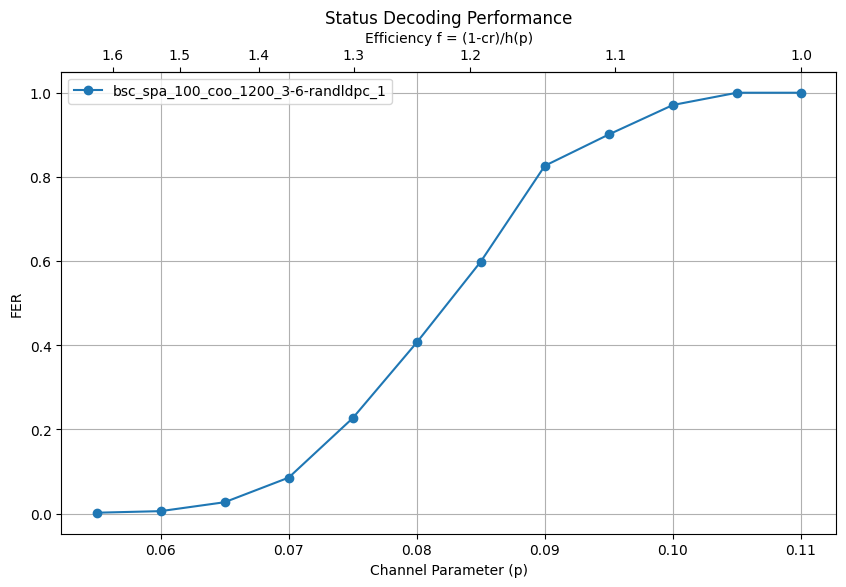

root|Done!


In [30]:
result = decoding_performance(
    channel_class,
    decoder,
    code,
    params,
    data_dirs,
    min_fec,
    log_freq,
    logger,
)

The same analysis is performed for the second irregular LDPC matrix

In [41]:
logger = setup_console_logger(level=logging.INFO)
channel = 'bsc'
decoder = 'spa'
max_iter = 100
min_fec = 100
log_freq = 5
code_name = "coo_1200_rho-x5-randldpc_2"
channel_class: Channel = channel_factory(channel)
decoder_class: BPA = decoder_factory(decoder)
code = get_code(code_name, data_dirs)
decoder = decoder_class(code.parity_mtx, max_iter=max_iter)
params = np.arange(0.11, 0.05, -0.005)

print(params)



[0.11  0.105 0.1   0.095 0.09  0.085 0.08  0.075 0.07  0.065 0.06  0.055]


root|Starting parameter: 0.110000
root|TOT:21, FEC:21, FER:1.0, BEC:2208, BER:0.08761904761904762
root|TOT:45, FEC:45, FER:1.0, BEC:4943, BER:0.09153703703703704
root|TOT:64, FEC:64, FER:1.0, BEC:6990, BER:0.091015625
root|TOT:88, FEC:88, FER:1.0, BEC:9467, BER:0.08964962121212121
root|TOT:100, FEC:100, FER:1.0, BEC:10679, BER:0.08899166666666666
root|Starting parameter: 0.105000
root|TOT:24, FEC:24, FER:1.0, BEC:2090, BER:0.07256944444444445
root|TOT:48, FEC:47, FER:0.9791666666666666, BEC:4067, BER:0.0706076388888889
root|TOT:71, FEC:70, FER:0.9859154929577465, BEC:5982, BER:0.0702112676056338
root|TOT:90, FEC:88, FER:0.9777777777777777, BEC:7596, BER:0.07033333333333333
root|TOT:102, FEC:100, FER:0.9803921568627451, BEC:8778, BER:0.0717156862745098
root|Starting parameter: 0.100000
root|TOT:22, FEC:20, FER:0.9090909090909091, BEC:1459, BER:0.05526515151515152
root|TOT:44, FEC:41, FER:0.9318181818181818, BEC:3159, BER:0.059829545454545455
root|TOT:67, FEC:62, FER:0.9253731343283582, 

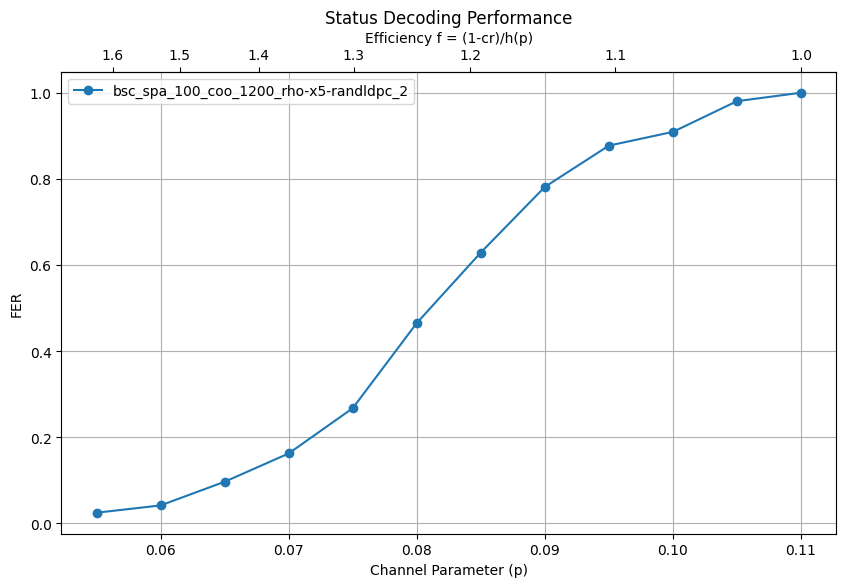

root|Done!


In [42]:
result = decoding_performance(
    channel_class,
    decoder,
    code,
    params,
    data_dirs,
    min_fec,
    log_freq,
    logger,
)

## Results

Let's print the results and then plot them using the Plots utilities:

## Importance of the max_iter parameter

/home/marcocofano/projects/qkd_reconciliation_lectures/code/error_correction/data/outputs


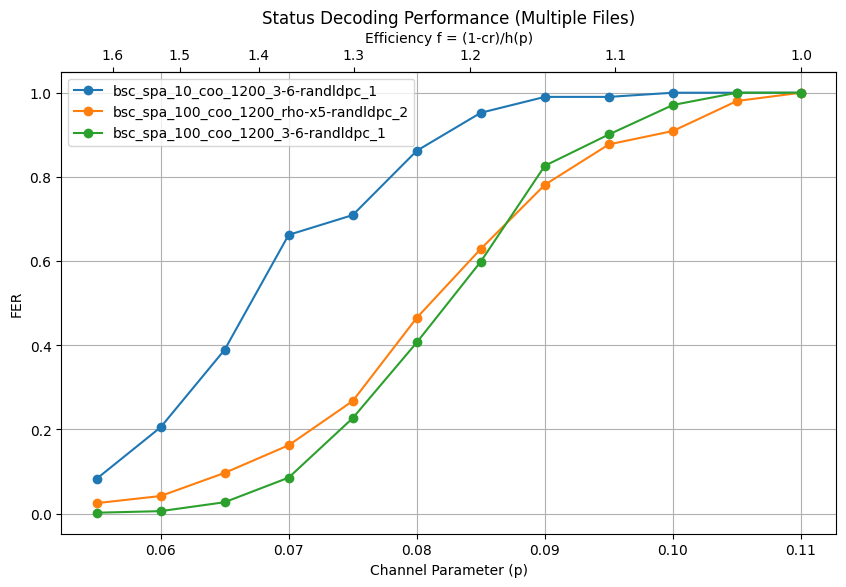

In [43]:
plotter.plot_from_dir(regex_pattern="bsc_spa_(\d+)_coo_1200_", cr=0.5)

# THE END - ignore the rest

In [63]:
%%time
from error_correction.codes import  save_parity_mtx, rand_reg_ldpc_improved
n= 10000
l=3
r=6
matrix = rand_reg_ldpc_improved(n,l,r)
config = CodeConfig(format="coo", code_length=10000, name=f"{l}-{r}-randldpc", seed=1)
new_code = Code(config=config, parity_mtx=matrix, data_dirs=data_dirs, )

CPU times: user 10.8 s, sys: 88.1 ms, total: 10.8 s
Wall time: 10.8 s


In [66]:
save_parity_mtx(new_code.parity_mtx, filepath=new_code.data_dirs.code_path('test'))

In [65]:
np.where(new_code.parity_mtx[0] != 0)

(array([ 254,  856, 1175, 1507, 8191, 8461]),)

In [67]:
channel = 'bsc'
decoder = 'spa'
max_iter = 100
min_fec = 100
log_freq = 5
code_name = "coo_10000_3-6-randldpc_1"
channel_class: Channel = channel_factory(channel)
decoder_class: BPA = decoder_factory(decoder)
code = get_code(code_name, data_dirs)
decoder = decoder_class(code.parity_mtx, max_iter=max_iter)
params = np.arange(0.11, 0.05, -0.005)

print(params)

[0.11  0.105 0.1   0.095 0.09  0.085 0.08  0.075 0.07  0.065 0.06  0.055]


In [68]:
result = decoding_performance(
    channel_class,
    decoder,
    code,
    params,
    data_dirs,
    min_fec,
    log_freq,
    logger,
)

root|Starting parameter: 0.110000
root|TOT:1, FEC:1, FER:1.0, BEC:982, BER:0.0982
root|TOT:2, FEC:2, FER:1.0, BEC:1952, BER:0.0976
root|TOT:3, FEC:3, FER:1.0, BEC:2991, BER:0.0997
root|TOT:4, FEC:4, FER:1.0, BEC:4081, BER:0.102025
root|TOT:5, FEC:5, FER:1.0, BEC:5125, BER:0.1025
root|TOT:6, FEC:6, FER:1.0, BEC:6122, BER:0.10203333333333334
root|TOT:7, FEC:7, FER:1.0, BEC:7057, BER:0.10081428571428572
root|TOT:8, FEC:8, FER:1.0, BEC:8108, BER:0.10135
root|
Signal received! Waiting for the critical section to finish...
root|TOT:9, FEC:9, FER:1.0, BEC:9209, BER:0.10232222222222222
root|Exiting early
root|TOT:9, FEC:9, FER:1.0, BEC:9209, BER:0.10232222222222222
root|Starting parameter: 0.105000
root|TOT:1, FEC:1, FER:1.0, BEC:932, BER:0.0932
root|TOT:2, FEC:2, FER:1.0, BEC:1938, BER:0.0969
root|TOT:3, FEC:3, FER:1.0, BEC:3011, BER:0.10036666666666667
root|TOT:4, FEC:4, FER:1.0, BEC:3984, BER:0.0996
root|TOT:5, FEC:5, FER:1.0, BEC:4861, BER:0.09722
root|TOT:6, FEC:6, FER:1.0, BEC:5790, BER:

root|TOT:97, FEC:97, FER:1.0, BEC:85170, BER:0.0878041237113402
root|TOT:98, FEC:98, FER:1.0, BEC:86005, BER:0.08776020408163265
root|TOT:99, FEC:99, FER:1.0, BEC:86885, BER:0.08776262626262626
root|TOT:100, FEC:100, FER:1.0, BEC:87811, BER:0.087811
root|TOT:100, FEC:100, FER:1.0, BEC:87811, BER:0.087811
root|Starting parameter: 0.095000
root|TOT:1, FEC:1, FER:1.0, BEC:752, BER:0.0752
root|TOT:2, FEC:2, FER:1.0, BEC:1565, BER:0.07825
root|TOT:3, FEC:3, FER:1.0, BEC:2431, BER:0.08103333333333333
root|TOT:4, FEC:4, FER:1.0, BEC:3068, BER:0.0767
root|TOT:5, FEC:5, FER:1.0, BEC:3788, BER:0.07576
root|TOT:6, FEC:6, FER:1.0, BEC:4683, BER:0.07805
root|TOT:7, FEC:7, FER:1.0, BEC:5396, BER:0.07708571428571429
root|TOT:8, FEC:8, FER:1.0, BEC:6223, BER:0.0777875
root|TOT:9, FEC:9, FER:1.0, BEC:6968, BER:0.07742222222222223
root|
Signal received! Waiting for the critical section to finish...
root|
Signal received! Waiting for the critical section to finish...
root|TOT:10, FEC:10, FER:1.0, BEC:780

KeyboardInterrupt: 